Music genre classification is important in identifying similar songs and building automated playlists based on a user's musical taste. We will explore classifying music in this notebook.  A collection of 10 genres with 100 audio files each, all having a length of 30 seconds (the famous GTZAN dataset, the MNIST of sounds) will be used.

## Import Packages

In [ ]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import os
import IPython
import librosa.display
import librosa

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from keras.layers import BatchNormalization

from sklearn.model_selection import train_test_split



In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Create a Helper Function to Plot Graphs:

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Mount Google Drive to Colab Environment

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Explore data

In [ ]:
os.walk('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/')


<generator object walk at 0x7f3adb8d0650>

In [ ]:
categories = []
for root, dirs, files in os.walk('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/', topdown=False):
    for name in dirs:
        categories.append(name)
        DIR=f"/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/{name}"
        files=len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
        print(f"{name}: {files} files")
        




classical: 100 files
pop: 100 files
hiphop: 100 files
rock: 100 files
disco: 100 files
metal: 100 files
jazz: 99 files
reggae: 100 files
blues: 100 files
country: 100 files


In [ ]:
categories.sort()

In [ ]:
categories

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

### Count image data

In [ ]:
for root, dirs, files in os.walk('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/images_original/', topdown=False):
    for name in dirs:
        DIR=f"/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/{name}"
        files=len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
        print(f"{name}: {files} files")

blues: 100 files
rock: 100 files
jazz: 99 files
classical: 100 files
country: 100 files
reggae: 100 files
metal: 100 files
pop: 100 files
hiphop: 100 files
disco: 100 files


After some inspection we can see that file 0054jazz.wav is bad and that the image is missing as well. We discarded this data from the set.

In [ ]:
audio='/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/blues/blues.00000.wav'
data , sampling_rate = librosa.load(audio)
print(type(data), type(sampling_rate))


<class 'numpy.ndarray'> <class 'int'>


In [ ]:
librosa.load(audio, sr=45600)

(array([ 0.007,  0.013,  0.017, ..., -0.073, -0.061, -0.03 ], dtype=float32),
 45600)

In [ ]:

IPython.display.Audio(data, rate=sampling_rate)

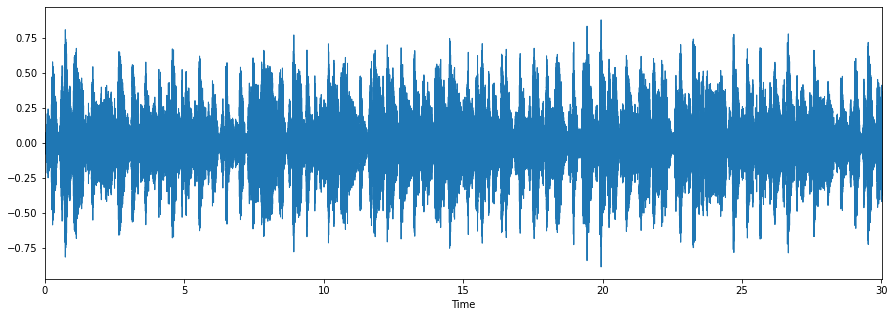

In [ ]:

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data)
plt.show()

In [ ]:
data

array([ 0.007,  0.017,  0.008, ..., -0.056, -0.061, -0.064], dtype=float32)

Text(0.5, 1.0, 'Harmonic + Percussive')

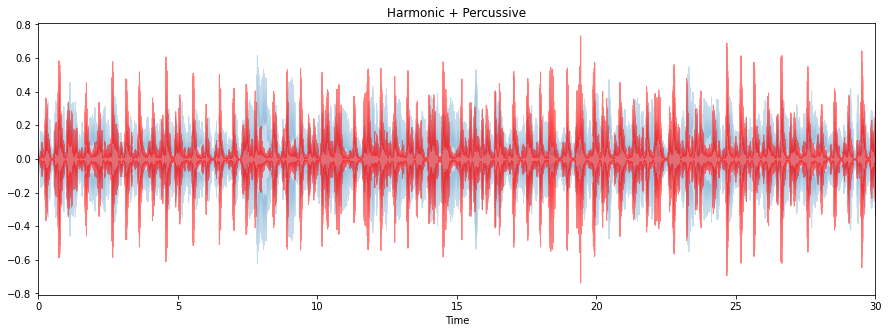

In [ ]:
plt.figure(figsize=(15, 5))
y_harm, y_perc = librosa.effects.hpss(data)
librosa.display.waveplot(y_harm, sr=sampling_rate, alpha=0.25)
librosa.display.waveplot(y_perc, sr=sampling_rate, color='r', alpha=0.5)
plt.title(label='Harmonic + Percussive')

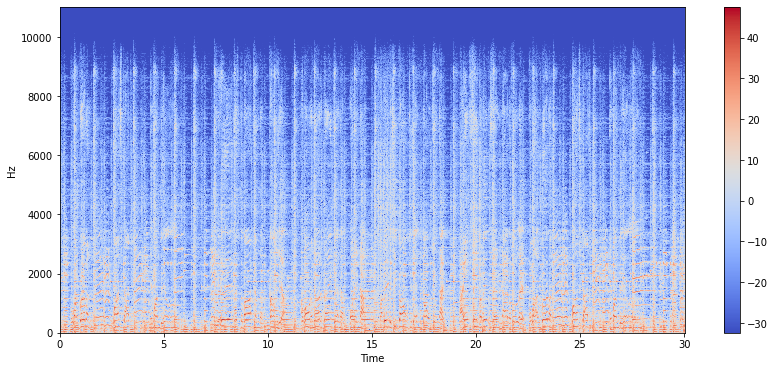

In [ ]:
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 6))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()

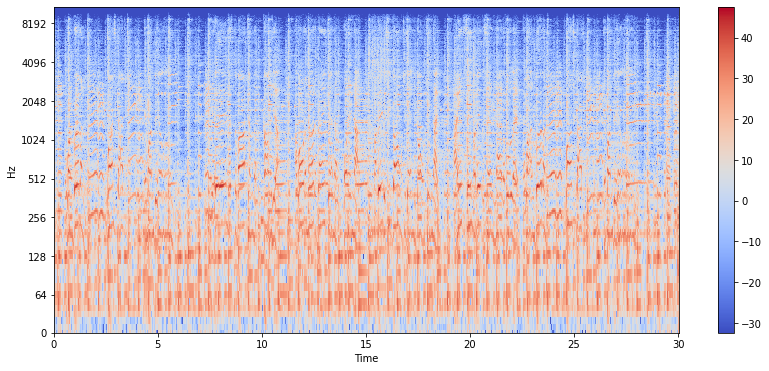

In [ ]:
plt.figure(figsize=(14, 6))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar()

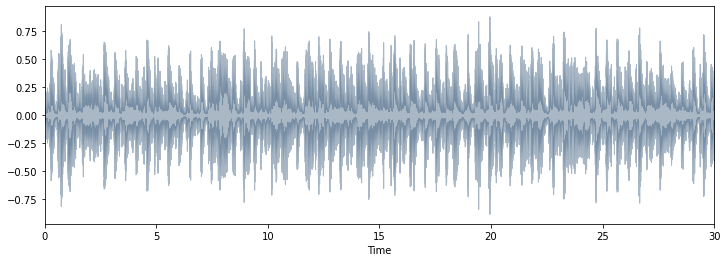

In [ ]:
from sklearn.preprocessing import normalize
spectral_rolloff = librosa.feature.spectral_rolloff(data+0.01, sr=sampling_rate)[0]
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate, alpha=0.4, color = "#2B4F72")

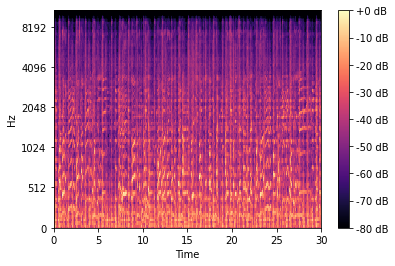

In [ ]:
S = librosa.feature.melspectrogram(data, sr=sampling_rate, n_fft=2048, hop_length=512, n_mels=128)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sampling_rate, hop_length=512, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

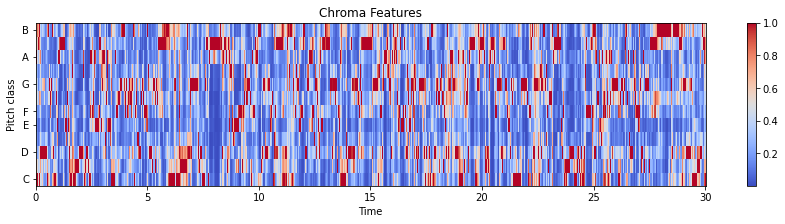

In [ ]:
chroma = librosa.feature.chroma_stft(data, sr=sampling_rate)
plt.figure(figsize=(15,3))
librosa.display.specshow(chroma, sr=sampling_rate, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

[Text(0.5, 1.0, 'MFCC')]

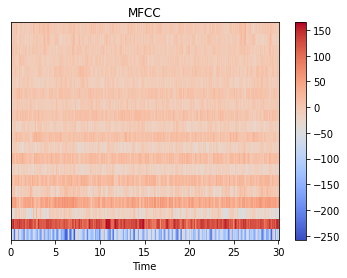

In [ ]:
mfcc=librosa.feature.mfcc(data, sr=sampling_rate)
fig, ax = plt.subplots()
img = librosa.display.specshow(mfcc, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

### Look at melspectrogram of hiphop song

In [ ]:
audio_hh1='/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/hiphop/hiphop.00000.wav'
datahh1 , sampling_rate = librosa.load(audio_hh1)
print(type(data), type(sampling_rate))

<class 'numpy.ndarray'> <class 'int'>


In [ ]:
librosa.load(audio_hh1, sr=45600)

(array([-0.163, -0.13 , -0.035, ..., -0.019, -0.017,  0.   ], dtype=float32),
 45600)

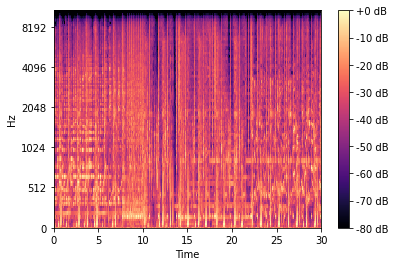

In [ ]:

S = librosa.feature.melspectrogram(datahh1, sr=sampling_rate, n_fft=2048, hop_length=512, n_mels=128)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sampling_rate, hop_length=512, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

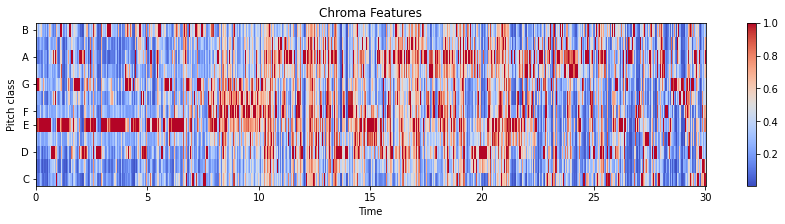

In [ ]:
chroma = librosa.feature.chroma_stft(datahh1, sr=sampling_rate)
plt.figure(figsize=(15,3))
librosa.display.specshow(chroma, sr=sampling_rate, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

## Look at CSV data

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/features_3_sec.csv')
df.head()

filename  length  chroma_stft_mean  ...  mfcc20_mean  mfcc20_var  label
0  blues.00000.0.wav   66149          0.335406  ...    -0.243027   43.771767  blues
1  blues.00000.1.wav   66149          0.343065  ...     5.784063   59.943081  blues
2  blues.00000.2.wav   66149          0.346815  ...     2.517375   33.105122  blues
3  blues.00000.3.wav   66149          0.363639  ...     3.630866   32.023678  blues
4  blues.00000.4.wav   66149          0.335579  ...     0.536961   29.146694  blues

[5 rows x 60 columns]

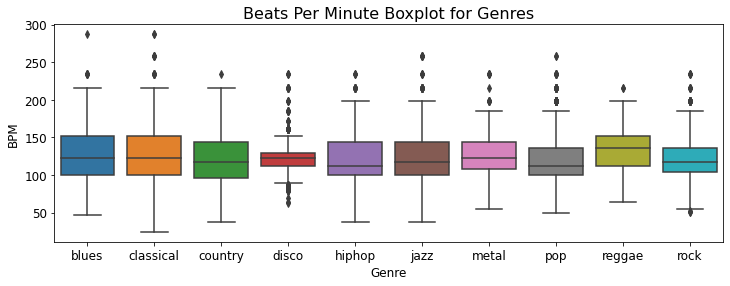

In [ ]:
import seaborn as sns
bpmdf = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(12, 4));
sns.boxplot(x = "label", y = "tempo", data = bpmdf);

plt.title('Beats Per Minute Boxplot for Genres', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);
plt.xlabel("Genre", fontsize = 12)
plt.ylabel("BPM", fontsize = 12)
plt.savefig("BPM_Boxplot.png")

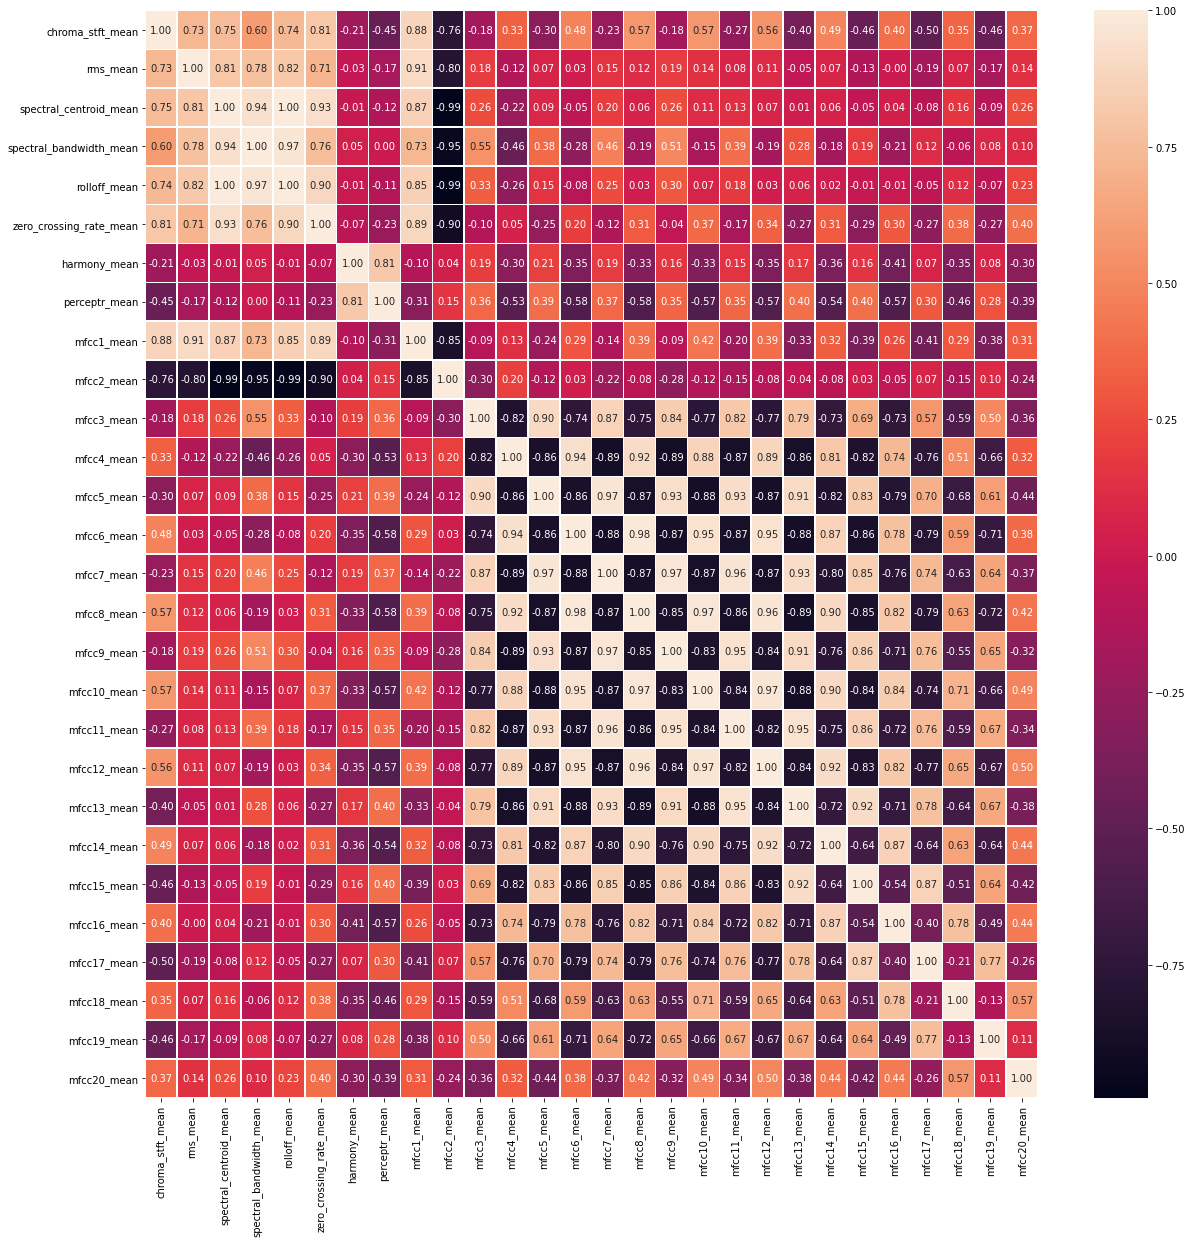

In [ ]:
heatmap_col= [col for col in df.columns if 'mean' in col]
heatmap_df = df[heatmap_col].corr()
f,ax = plt.subplots(figsize=(20, 20))
sns.heatmap(heatmap_df.corr(), annot=True, linewidths=0.5, fmt= '.2f',ax=ax)

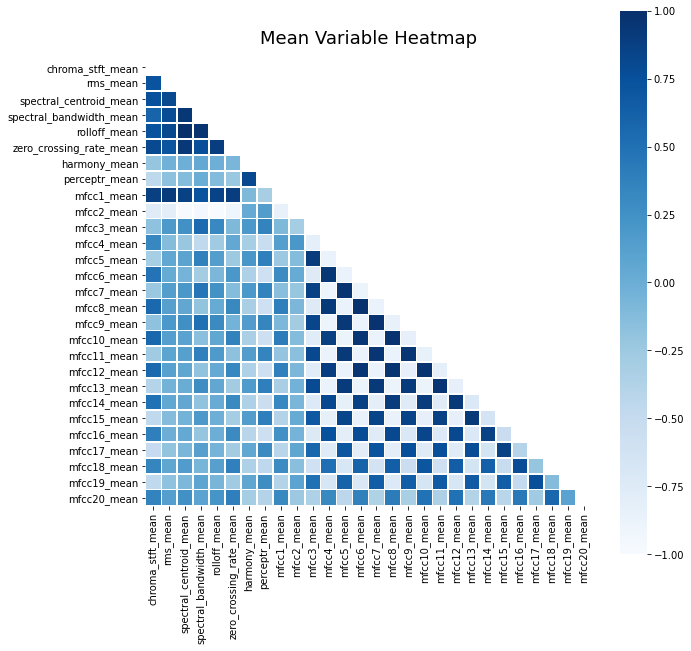

In [ ]:
f,ax = plt.subplots(figsize=(10, 10))
mask = np.triu(np.ones_like(heatmap_df.corr(), dtype=np.bool))
heatmap = sns.heatmap(heatmap_df.corr(), mask=mask, vmin=-1, vmax=1, square=True, linewidths=.5,cmap='Blues',ax=ax)
heatmap.set_title('Mean Variable Heatmap', fontdict={'fontsize':18}, pad=16);

## Save Mel Spectogram data

In [ ]:
#Constants
DATASET_PATH = '/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/'
JSON_PATH = "/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [ ]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
  #Create JSON data structure
  data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

  samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
  num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

  # loop through all genre sub-folder
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
          
      if dirpath is not dataset_path:
            
          # save genre label (i.e., sub-folder name) in the mapping
          semantic_label = dirpath.split("/")[-1]
          data["mapping"].append(semantic_label)
          print("\nProcessing: {}".format(semantic_label))
            
          # process all audio files in genre sub-dir
          for f in filenames:

		          # load audio file
              file_path = os.path.join(dirpath, f)

              signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
              # process all segments of audio file
              for d in range(num_segments):
                # calculate start and finish sample for current segment
                start = samples_per_segment * d
                finish = start + samples_per_segment

                # extract mfcc
                mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                mfcc = mfcc.T

                # store only mfcc feature with expected number of vectors
                if len(mfcc) == num_mfcc_vectors_per_segment:
                    data["mfcc"].append(mfcc.tolist())
                    data["labels"].append(i-1)
                    print("{}, segment:{}".format(file_path, d+1))
                  
  # save MFCCs to json file
  with open(json_path, "w") as fp:
      json.dump(data, fp, indent=4)

In [ ]:

# Runs Data Processing     
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=6)


Streaming output truncated to the last 5000 lines.
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/disco/disco.00096.wav, segment:10

Processing: metal
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/metal/metal.00009.wav, segment:1
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/metal/metal.00009.wav, segment:2
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/metal/metal.00009.wav, segment:3
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/metal/metal.00009.wav, segment:4
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/metal/metal.00009.wav, segment:5
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/metal/metal.00009.wav, segment:6
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/metal/metal.00009.wav, segment:7
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original

## Try another way to build preprocessed data

In [ ]:
import glob

rootdir_glob = "/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original"      # songs parent folder
path_save = "/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/mcc32"     # folder where to store outputs spectograms
size_image = 256                      # will be saved as [size_image x size_image x 3 channels] with bit depth of 32

sampling_rate = 22050                    # Sample rate used to determine time scale in x-axis (taken from the song files).
hop_length = 512                        # Hop length, also used to determine time scale in x-axis (not used yet)
y = 'mel'                               # Frequency types

    # Create target directory & all intermediate directories if don't exists
    # Create target directory & all intermediate directories if don't exists
try:
    os.makedirs(path_save)    
    print("Directory " , path_save ,  " Created ")
except FileExistsError:
    pass

i = 0

# loop through all genre sub-folder
for count_enum, (dirpath, dirnames, filenames) in enumerate(os.walk(rootdir_glob)):

  if dirpath is not rootdir_glob:
    for filename in glob.iglob(dirpath + "//*", recursive=True):
      print(filename)
      genre = filename.split('/')[-2]
        # Create target directory & all intermediate directories if don't exists
      try:
          os.makedirs(path_save + '/' + genre)    
          print("Directory " , path_save + '/' + genre ,  " Created ")
      except FileExistsError:
          pass

        
      if os.path.isfile(filename): # filter dirs
          x, sampleRate = librosa.load(filename, duration = 30)
          fig = plt.figure(figsize=(1, 1), frameon=False,  dpi=size_image)
          ax = plt.Axes(fig, [0., 0., 1., 1.])
          ax.set_axis_off()
          fig.add_axes(ax)
          #X = librosa.stft(x) Old way of creating the the spectrogram.
          X = librosa.feature.mfcc(x, sr=sampleRate) #Creating the melspectrogram
          #Xdb = librosa.amplitude_to_db(abs(X))
          librosa.display.specshow(X, sr=sampling_rate,  cmap='gray_r', x_axis='time', y_axis=y)
          plt.savefig(path_save + '/' + genre + '/spectrogram_'+ str("{:04d}".format(i)) + '.png',  transparent=True, pad_inches=0.0, dpi=size_image)
          plt.close(fig)
          if(i % 100 == 0):
              print("Done processing ",i , " songs")
          i = i + 1
        

print('Conversion to spectograms complete.')
print('Converted songs: ' + str(i))

Directory  /content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/mcc32  Created 
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/classical/classical.00000.wav
Directory  /content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/mcc32/classical  Created 
Done processing  0  songs
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/classical/classical.00026.wav
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/classical/classical.00005.wav
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/classical/classical.00019.wav
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/classical/classical.00027.wav
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/classical/classical.00016.wav
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/classical/classical.00028.wav
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_o

In [ ]:
#Create Labels
path_save = "/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/"        
name_file = "labels.txt"  # name of created .txt file

labels = np.repeat(range(10), 100)     
labels = labels.astype(np.int64)
np.savetxt(path_save + name_file, labels, fmt="%d")

## Build CNN

In [ ]:
DATA='/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/data_10.json'


In [ ]:
def clean_data(data):
  
  with open(data,"r") as f:
    music_data=json.load(f)

  mfcc= np.array(music_data["mfcc"])
  labels= np.array(music_data["labels"])
  mapping = np.array(music_data['mapping'])
  return mfcc, labels, mapping


In [ ]:
def split_data(tsize,vsize):

  mfcc, labels, mapping=clean_data(DATA)
  # create train, validation and test split
  X_train, X_test, y_train, y_test = train_test_split(mfcc, labels, test_size=tsize)
  X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=vsize)

  # add an axis to input sets
  X_train = X_train[..., np.newaxis]
  X_validation = X_validation[..., np.newaxis]
  X_test = X_test[..., np.newaxis]

  return X_train, X_validation, X_test, y_train, y_validation, y_test, mapping

In [ ]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test, z = split_data(0.1, 0.1)

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [ ]:
input_shape

(130, 13, 1)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=input_shape))
model.add(layers.MaxPooling2D((3, 3),strides=2,padding='same'))
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPooling2D(pool_size=(3, 3),strides=2,padding='same'))
model.add(layers.Conv2D(filters=1024, kernel_size=(2, 2), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2,padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 257, 11, 256)      2560      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 129, 6, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 127, 4, 512)       1180160   
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 2, 512)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 63, 1, 1024)       2098176   
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 1, 1024)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)            

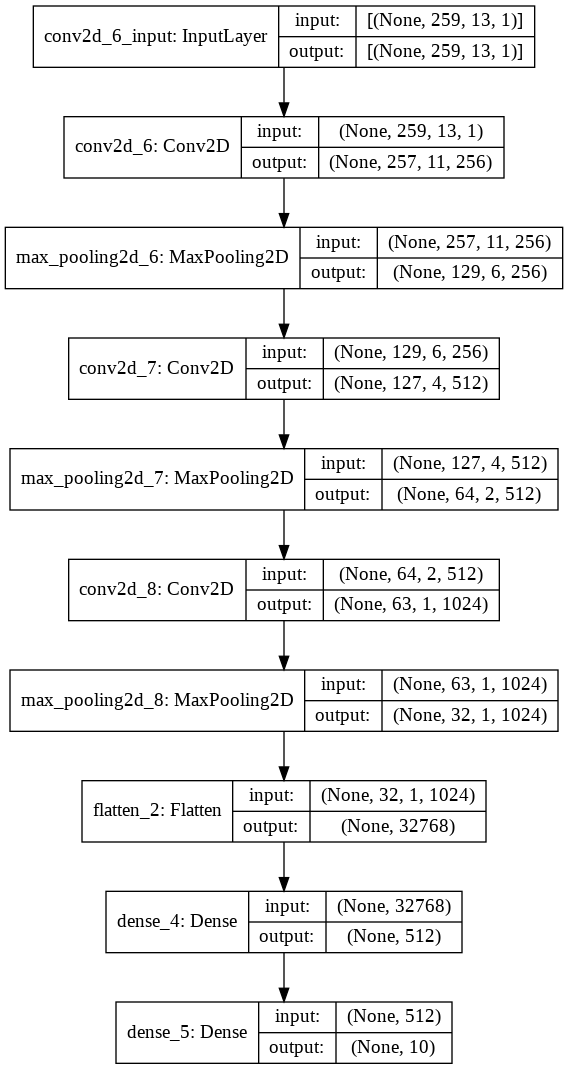

In [ ]:
keras.utils.plot_model(model, "assignment4model.png", show_shapes=True) 

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train
                    ,y_train
                    ,epochs=200
                    ,validation_data=(X_validation,y_validation)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
152/152 [==============================] - 407s 3s/step - loss: 1.9272 - accuracy: 0.3992 - val_loss: 1.3731 - val_accuracy: 0.5148
Epoch 2/200
152/152 [==============================] - 409s 3s/step - loss: 1.3677 - accuracy: 0.4864 - val_loss: 1.2631 - val_accuracy: 0.5130
Epoch 3/200
152/152 [==============================] - 406s 3s/step - loss: 1.1643 - accuracy: 0.5826 - val_loss: 1.2169 - val_accuracy: 0.5352
Epoch 4/200
152/152 [==============================] - 404s 3s/step - loss: 0.9658 - accuracy: 0.6519 - val_loss: 1.2218 - val_accuracy: 0.5685
Epoch 5/200
152/152 [==============================] - 405s 3s/step - loss: 0.7907 - accuracy: 0.7197 - val_loss: 1.0737 - val_accuracy: 0.6444
Epoch 6/200
152/152 [==============================] - 403s 3s/step - loss: 0.6425 - accuracy: 0.7702 - val_loss: 1.1488 - val_accuracy: 0.6296
Epoch 7/200
152/152 [==============================] - 402s 3s/step - loss: 0.4488 - accuracy: 0.8448 - val_loss: 1.1627 - val_accuracy:

## Data with 1 segment image

In [ ]:
JSON_PATH = "/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/data_1.json"
DATA='/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/data_1.json'

In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=1)

In [ ]:
from sklearn.model_selection import train_test_split
import json
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test, z = split_data(0.1, 0.1)

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from keras.layers import BatchNormalization

model2 = models.Sequential()
model2.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=input_shape))
model2.add(layers.MaxPooling2D((3, 3),strides=2,padding='same'))
model2.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model2.add(layers.MaxPooling2D(pool_size=(3, 3),strides=2,padding='same'))
model2.add(layers.Conv2D(filters=1024, kernel_size=(2, 2), strides=(1, 1), activation=tf.nn.relu))
model2.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2,padding='same'))
model2.add(layers.Flatten())
model2.add(layers.Dense(units=512, activation=tf.nn.relu))
model2.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history2 = model2.fit(X_train
                    ,y_train
                    ,epochs=200
                    ,validation_data=(X_validation,y_validation)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Models/Model2/model2_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
26/26 [==============================] - 388s 15s/step - loss: 118.4266 - accuracy: 0.1378 - val_loss: 2.1556 - val_accuracy: 0.2556
Epoch 2/200
26/26 [==============================] - 390s 15s/step - loss: 1.8583 - accuracy: 0.3236 - val_loss: 1.6393 - val_accuracy: 0.4444
Epoch 3/200
26/26 [==============================] - 383s 15s/step - loss: 1.3766 - accuracy: 0.5203 - val_loss: 1.8308 - val_accuracy: 0.4444
Epoch 4/200
26/26 [==============================] - 388s 15s/step - loss: 1.1820 - accuracy: 0.5859 - val_loss: 1.6307 - val_accuracy: 0.4778
Epoch 5/200
26/26 [==============================] - 389s 15s/step - loss: 0.9542 - accuracy: 0.6857 - val_loss: 1.7254 - val_accuracy: 0.5222
Epoch 6/200
26/26 [==============================] - 382s 15s/step - loss: 0.6658 - accuracy: 0.7847 - val_loss: 2.2028 - val_accuracy: 0.4222
Epoch 7/200
26/26 [==============================] - 386s 15s/step - loss: 0.5294 - accuracy: 0.8283 - val_loss: 1.6698 - val_accuracy: 0.57

In [ ]:
loss, accuracy = model2.evaluate(X_test, y_test)
print('test set accuracy: ', accuracy * 100)

4/4 [==============================] - 13s 3s/step - loss: 2.7062 - accuracy: 0.3700
test set accuracy:  37.00000047683716


## Try Provided Image Data

In [ ]:
image_data = '/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/images_original/'

In [ ]:
BATCH_SIZE=8
TARGET_SIZE=224
NUM_CLASSES=10

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_ds = image_dataset_from_directory(
  image_data,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(TARGET_SIZE, TARGET_SIZE),
  batch_size=BATCH_SIZE)

Found 999 files belonging to 10 classes.
Using 800 files for training.


In [ ]:
val_ds = image_dataset_from_directory(
  image_data,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(TARGET_SIZE, TARGET_SIZE),
  batch_size=BATCH_SIZE)

Found 999 files belonging to 10 classes.
Using 199 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


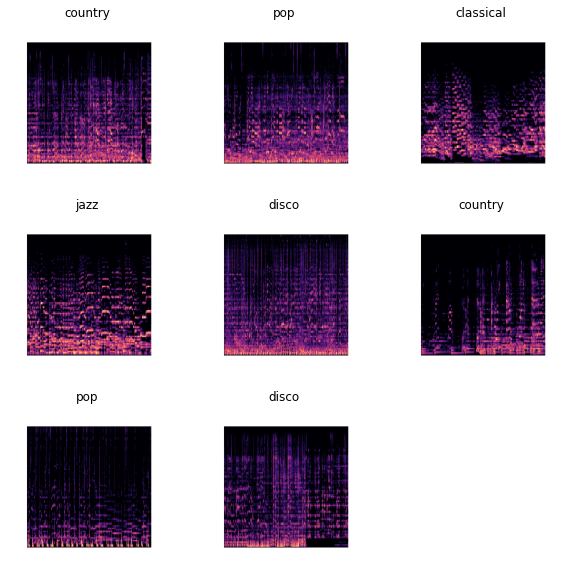

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
model3 = models.Sequential()
model3.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(TARGET_SIZE, TARGET_SIZE, 3)))
model3.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(TARGET_SIZE, TARGET_SIZE, 3)))
model3.add(layers.MaxPooling2D((3, 3),strides=2))
model3.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model3.add(layers.MaxPooling2D(pool_size=(3, 3),strides=2))
model3.add(layers.Conv2D(filters=1024, kernel_size=(2, 2), strides=(1, 1), activation=tf.nn.relu))
model3.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model3.add(layers.Flatten())
model3.add(layers.Dense(units=512, activation=tf.nn.relu))
model3.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 510, 510, 256)     7168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 254, 254, 256)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 252, 252, 512)     1180160   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 125, 125, 512)     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 124, 124, 1024)    2098176   
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 1024)     

In [ ]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_ds
                    ,epochs=200
                    ,validation_data=(val_ds)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Models/Model3/model3_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
100/100 [==============================] - 2350s 23s/step - loss: 5.4306 - accuracy: 0.1382 - val_loss: 2.1155 - val_accuracy: 0.2261
Epoch 2/200
100/100 [==============================] - 2135s 21s/step - loss: 1.9702 - accuracy: 0.2832 - val_loss: 1.7070 - val_accuracy: 0.3568
Epoch 3/200
100/100 [==============================] - 2134s 21s/step - loss: 1.4594 - accuracy: 0.4685 - val_loss: 1.5414 - val_accuracy: 0.4523
Epoch 4/200
100/100 [==============================] - 2155s 22s/step - loss: 1.0893 - accuracy: 0.6057 - val_loss: 2.0186 - val_accuracy: 0.3668
Epoch 5/200
100/100 [==============================] - 2132s 21s/step - loss: 0.7360 - accuracy: 0.7560 - val_loss: 1.8043 - val_accuracy: 0.4824
Epoch 6/200
100/100 [==============================] - 2154s 22s/step - loss: 0.3387 - accuracy: 0.8994 - val_loss: 2.3903 - val_accuracy: 0.4874
Epoch 7/200
100/100 [==============================] - 2160s 22s/step - loss: 0.1649 - accuracy: 0.9363 - val_loss: 2.7924 -

KeyboardInterrupt: ignored

### CNN Model Using Regularization and BW data spectrograms created

In [ ]:
#image_data='/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/spectrograms512_train'
image_data='/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/images_original/'
#image_data='/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/mcc32/'

In [ ]:
BATCH_SIZE=6
TARGET_SIZE=32
NUM_CLASSES=10

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_ds = image_dataset_from_directory(
  image_data,
  color_mode='grayscale',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(TARGET_SIZE, TARGET_SIZE),
  batch_size=BATCH_SIZE)

Found 999 files belonging to 10 classes.
Using 800 files for training.


In [ ]:
val_ds = image_dataset_from_directory(
  image_data,
  validation_split=0.2,
  color_mode='grayscale',
  subset="validation",
  seed=123,
  image_size=(TARGET_SIZE, TARGET_SIZE),
  batch_size=BATCH_SIZE)

Found 999 files belonging to 10 classes.
Using 199 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from keras.layers import BatchNormalization
from keras_preprocessing.image import ImageDataGenerator

model4 = models.Sequential()
model4.add(layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(TARGET_SIZE, TARGET_SIZE, 1)))
model4.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model4.add(layers.MaxPooling2D((2, 2),strides=2))
model4.add(layers.Dropout(.2))
model4.add(layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model4.add(BatchNormalization())
model4.add(layers.Flatten())
model4.add(layers.Dense(units=32, activation=tf.nn.relu))
model4.add(layers.Dense(units=10, activation=tf.nn.softmax))

ValueError: ignored

In [ ]:
model4.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 30, 30, 16)        160       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 12, 12, 16)        4624      
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 16)        64        
_________________________________________________________________
flatten_9 (Flatten)          (None, 2304)             

In [ ]:
model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:

history4 = model4.fit(train_ds
                    ,epochs=200
                    ,validation_data=(val_ds)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Models/Model4/model4_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
134/134 [==============================] - 112s 833ms/step - loss: 2.4102 - accuracy: 0.0804 - val_loss: 2.2834 - val_accuracy: 0.1206
Epoch 2/200
134/134 [==============================] - 7s 49ms/step - loss: 2.2970 - accuracy: 0.1032 - val_loss: 2.2814 - val_accuracy: 0.0955
Epoch 3/200
134/134 [==============================] - 7s 50ms/step - loss: 2.2990 - accuracy: 0.0972 - val_loss: 2.2751 - val_accuracy: 0.1307
Epoch 4/200
134/134 [==============================] - 7s 50ms/step - loss: 2.2274 - accuracy: 0.1538 - val_loss: 2.5481 - val_accuracy: 0.1055
Epoch 5/200
134/134 [==============================] - 7s 50ms/step - loss: 2.1995 - accuracy: 0.1498 - val_loss: 2.2744 - val_accuracy: 0.1357
Epoch 6/200
134/134 [==============================] - 7s 50ms/step - loss: 2.1777 - accuracy: 0.1651 - val_loss: 2.4046 - val_accuracy: 0.1307
Epoch 7/200
134/134 [==============================] - 7s 51ms/step - loss: 2.1606 - accuracy: 0.1636 - val_loss: 2.2610 - val_accura

KeyboardInterrupt: ignored

first time had accurace 12.34% and val accuracy of 9.05%

### Try with 10 piece segment data of clips broken down to 3 seconds each to create more data

In [ ]:
JSON_PATH = "/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/data_10_segments.json"
DATA='/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/data_10_segments.json'
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

In [ ]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test, z = split_data(0.1, 0.1)
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [ ]:
model5 = models.Sequential()
model5.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=input_shape))
model5.add(layers.MaxPooling2D((3, 3),strides=2,padding='same'))
model5.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model5.add(layers.MaxPooling2D(pool_size=(3, 3),strides=2,padding='same'))
model5.add(layers.Conv2D(filters=1024, kernel_size=(2, 2), strides=(1, 1), activation=tf.nn.relu))
model5.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2,padding='same'))
model5.add(layers.Flatten())
model5.add(layers.Dense(units=512, activation=tf.nn.relu))
model5.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 256)      2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 256)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 512)        1180160   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 512)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 1, 1024)       2098176   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 1, 1024)       0         
_________________________________________________________________
flatten (Flatten)            (None, 15360)             0

In [ ]:
model5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history5 = model5.fit(X_train
                    ,y_train
                    ,epochs=200
                    ,validation_data=(X_validation,y_validation)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Models/Model5/model5_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
253/253 [==============================] - 49s 193ms/step - loss: 6.7852 - accuracy: 0.2989 - val_loss: 1.4186 - val_accuracy: 0.4694
Epoch 2/200
253/253 [==============================] - 48s 191ms/step - loss: 1.3860 - accuracy: 0.4850 - val_loss: 1.2369 - val_accuracy: 0.5506
Epoch 3/200
253/253 [==============================] - 48s 189ms/step - loss: 1.2262 - accuracy: 0.5420 - val_loss: 1.2040 - val_accuracy: 0.5506
Epoch 4/200
253/253 [==============================] - 47s 187ms/step - loss: 1.0311 - accuracy: 0.6221 - val_loss: 1.1424 - val_accuracy: 0.5795
Epoch 5/200
253/253 [==============================] - 48s 188ms/step - loss: 0.9104 - accuracy: 0.6663 - val_loss: 1.1435 - val_accuracy: 0.5884
Epoch 6/200
253/253 [==============================] - 47s 187ms/step - loss: 0.7361 - accuracy: 0.7379 - val_loss: 1.2021 - val_accuracy: 0.5951
Epoch 7/200
253/253 [==============================] - 47s 187ms/step - loss: 0.5990 - accuracy: 0.7819 - val_loss: 1.1670 -

In [ ]:
loss, accuracy = model5.evaluate(X_test, y_test)
print('test set accuracy: ', accuracy * 100)

32/32 [==============================] - 1s 30ms/step - loss: 1.3949 - accuracy: 0.6226
test set accuracy:  62.26226091384888


### Try with 3 piece segment data of clips broken down to 10 seconds each to create more data

In [ ]:
JSON_PATH = "/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/data_3_segments.json"
DATA='/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/data_3_segments.json'
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=3)


Processing: classical
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/classical/classical.00000.wav, segment:1
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/classical/classical.00000.wav, segment:2
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/classical/classical.00000.wav, segment:3
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/classical/classical.00026.wav, segment:1
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/classical/classical.00026.wav, segment:2
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/classical/classical.00026.wav, segment:3
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/classical/classical.00005.wav, segment:1
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/genres_original/classical/classical.00005.wav, segment:2
/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data

In [ ]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test, z = split_data(0.1, 0.1)
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [ ]:
model6 = models.Sequential()
model6.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=input_shape))
model6.add(layers.MaxPooling2D((3, 3),strides=2,padding='same'))
model6.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model6.add(layers.MaxPooling2D(pool_size=(3, 3),strides=2,padding='same'))
model6.add(layers.Conv2D(filters=1024, kernel_size=(2, 2), strides=(1, 1), activation=tf.nn.relu))
model6.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2,padding='same'))
model6.add(layers.Flatten())
model6.add(layers.Dense(units=512, activation=tf.nn.relu))
model6.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model6.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 429, 11, 256)      2560      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 215, 6, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 213, 4, 512)       1180160   
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 107, 2, 512)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 106, 1, 1024)      2098176   
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 53, 1, 1024)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 54272)            

In [ ]:
model6.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history6 = model6.fit(X_train
                    ,y_train
                    ,epochs=200
                    ,validation_data=(X_validation,y_validation)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Models/Model56/model6_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
76/76 [==============================] - 33s 429ms/step - loss: 25.5525 - accuracy: 0.2298 - val_loss: 1.5040 - val_accuracy: 0.4370
Epoch 2/200
76/76 [==============================] - 33s 429ms/step - loss: 1.5002 - accuracy: 0.4357 - val_loss: 1.4590 - val_accuracy: 0.4704
Epoch 3/200
76/76 [==============================] - 33s 435ms/step - loss: 1.3773 - accuracy: 0.4937 - val_loss: 1.5016 - val_accuracy: 0.4148
Epoch 4/200
76/76 [==============================] - 32s 426ms/step - loss: 1.2370 - accuracy: 0.5547 - val_loss: 1.2310 - val_accuracy: 0.5519
Epoch 5/200
76/76 [==============================] - 32s 424ms/step - loss: 1.0096 - accuracy: 0.6303 - val_loss: 1.3028 - val_accuracy: 0.5407
Epoch 6/200
76/76 [==============================] - 32s 422ms/step - loss: 0.7726 - accuracy: 0.7145 - val_loss: 1.3711 - val_accuracy: 0.5000


In [ ]:
loss, accuracy = model6.evaluate(X_test, y_test)
print('test set accuracy: ', accuracy * 100)

10/10 [==============================] - 1s 86ms/step - loss: 1.2996 - accuracy: 0.5533
test set accuracy:  55.33333420753479


### Try clips split into 5 segments of 6 seconds each

In [ ]:
JSON_PATH = "/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/data_5_segments.json"
DATA='/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/data_5_segments.json'


In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=5)

In [ ]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test, z = split_data(0.1, 0.1)
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [ ]:
model7 = models.Sequential()
model7.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=input_shape))
model7.add(layers.MaxPooling2D((3, 3),strides=2,padding='same'))
model7.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model7.add(layers.MaxPooling2D(pool_size=(3, 3),strides=2,padding='same'))
model7.add(layers.Conv2D(filters=1024, kernel_size=(2, 2), strides=(1, 1), activation=tf.nn.relu))
model7.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2,padding='same'))
model7.add(layers.Flatten())
model7.add(layers.Dense(units=512, activation=tf.nn.relu))
model7.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model7.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 257, 11, 256)      2560      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 129, 6, 256)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 127, 4, 512)       1180160   
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 2, 512)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 63, 1, 1024)       2098176   
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 1, 1024)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)            

In [ ]:
model7.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history7 = model7.fit(X_train
                    ,y_train
                    ,epochs=200
                    ,validation_data=(X_validation,y_validation)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Models/Model7/model7_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
127/127 [==============================] - 44s 343ms/step - loss: 12.5861 - accuracy: 0.2913 - val_loss: 1.2476 - val_accuracy: 0.5267
Epoch 2/200
127/127 [==============================] - 44s 344ms/step - loss: 1.3829 - accuracy: 0.4948 - val_loss: 1.2977 - val_accuracy: 0.5244
Epoch 3/200
127/127 [==============================] - 43s 341ms/step - loss: 1.0787 - accuracy: 0.6026 - val_loss: 1.1613 - val_accuracy: 0.5600
Epoch 4/200
127/127 [==============================] - 43s 342ms/step - loss: 0.9546 - accuracy: 0.6675 - val_loss: 1.0048 - val_accuracy: 0.6600
Epoch 5/200
127/127 [==============================] - 44s 345ms/step - loss: 0.6581 - accuracy: 0.7568 - val_loss: 0.9952 - val_accuracy: 0.6600
Epoch 6/200
127/127 [==============================] - 44s 343ms/step - loss: 0.5702 - accuracy: 0.7945 - val_loss: 1.0178 - val_accuracy: 0.6756
Epoch 7/200
127/127 [==============================] - 44s 343ms/step - loss: 0.3284 - accuracy: 0.8878 - val_loss: 1.3059 

In [ ]:
model7 = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Models/Model7/model7_0.6956.h5')

In [ ]:
loss, accuracy = model7.evaluate(X_test, y_test)
print('test set accuracy: ', accuracy * 100)

16/16 [==============================] - 1s 56ms/step - loss: 1.4092 - accuracy: 0.6260
test set accuracy:  62.59999871253967


# Take model 7 an add regularization

In [ ]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test, z = split_data(0.1, 0.1)
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [ ]:
model8 = models.Sequential()
model8.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=input_shape))
model8.add(layers.MaxPooling2D((3, 3),strides=2,padding='same'))
model8.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model8.add(layers.MaxPooling2D(pool_size=(3, 3),strides=2,padding='same'))
model8.add(layers.Dropout(.3))
model8.add(layers.Conv2D(filters=1024, kernel_size=(2, 2), strides=(1, 1), activation=tf.nn.relu))
model8.add(BatchNormalization())
model8.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2,padding='same'))
model8.add(layers.Dropout(.3))
model8.add(layers.Flatten())
model8.add(layers.Dense(units=512, activation=tf.nn.relu))
model8.add(layers.Dense(units=10, activation=tf.nn.softmax))


In [ ]:
model8.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 257, 11, 256)      2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 129, 6, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 4, 512)       1180160   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 2, 512)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 2, 512)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 1, 1024)       2098176   
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 1, 1024)       4

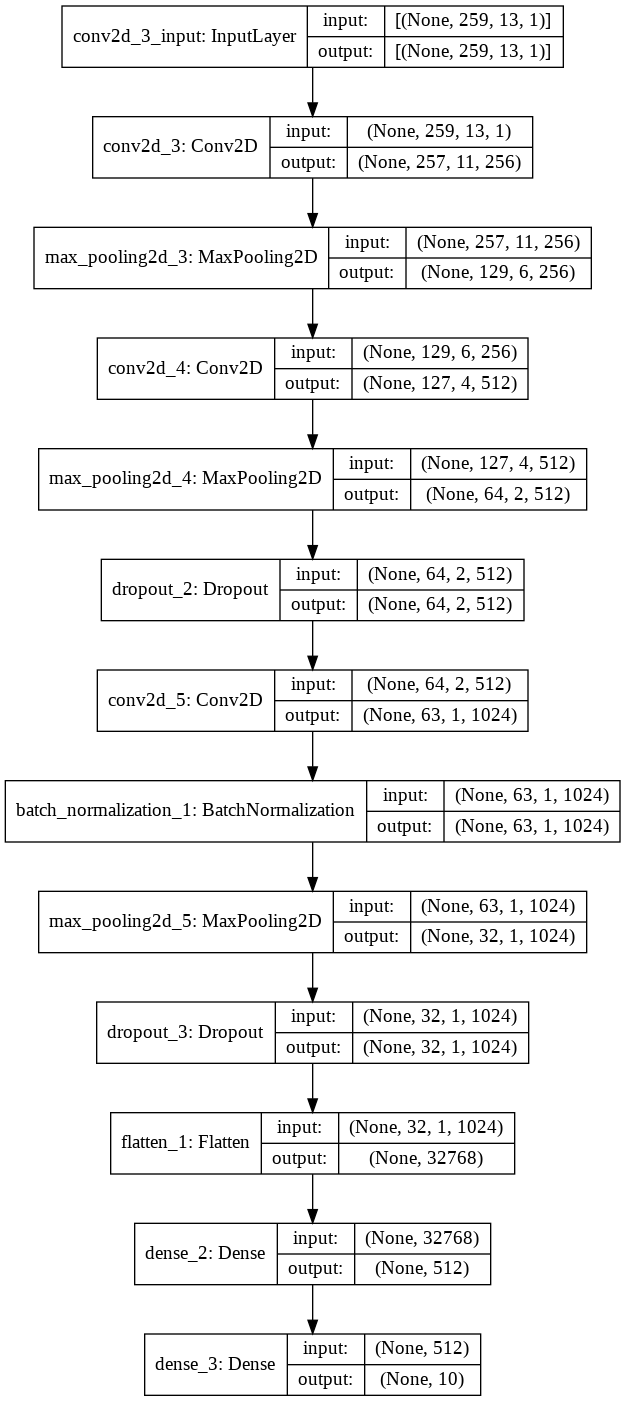

In [ ]:
keras.utils.plot_model(model8, "model8.png", show_shapes=True) 

In [ ]:
model8.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history8 = model8.fit(X_train
                    ,y_train
                    ,epochs=20
                    ,validation_data=(X_validation,y_validation)
                    ,callbacks=[
                   # tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
                    #tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Models/Model8/model8_{val_accuracy:.4f}.h5', save_best_only=True,
                    #                    save_weights_only=False, monitor='val_accuracy')
                    ]                                                                                                           
                   )

Epoch 1/20
127/127 [==============================] - 51s 405ms/step - loss: 0.3210 - accuracy: 0.8939 - val_loss: 2.5170 - val_accuracy: 0.5667
Epoch 2/20
127/127 [==============================] - 51s 403ms/step - loss: 0.2857 - accuracy: 0.8998 - val_loss: 1.8285 - val_accuracy: 0.6422
Epoch 3/20
127/127 [==============================] - 51s 403ms/step - loss: 0.2812 - accuracy: 0.9068 - val_loss: 1.8604 - val_accuracy: 0.6533
Epoch 4/20
127/127 [==============================] - 52s 406ms/step - loss: 0.2711 - accuracy: 0.9080 - val_loss: 3.0122 - val_accuracy: 0.5489
Epoch 5/20
127/127 [==============================] - 52s 406ms/step - loss: 0.2145 - accuracy: 0.9300 - val_loss: 4.4877 - val_accuracy: 0.6022
Epoch 6/20
127/127 [==============================] - 53s 421ms/step - loss: 0.1371 - accuracy: 0.9545 - val_loss: 1.9097 - val_accuracy: 0.6756
Epoch 7/20
127/127 [==============================] - 51s 405ms/step - loss: 0.1498 - accuracy: 0.9515 - val_loss: 1.8761 - val_ac

In [ ]:
model8 = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Models/Model8/model8_0.6978.h5')

In [ ]:
loss, accuracy = model8.evaluate(X_test, y_test)
print('test set accuracy: ', accuracy * 100)

16/16 [==============================] - 1s 67ms/step - loss: 2.6075 - accuracy: 0.6760
test set accuracy:  67.59999990463257


In [ ]:
pred_classes = np.argmax(model8.predict(X_test), axis=-1)
pred_classes

array([5, 1, 0, 6, 3, 1, 5, 6, 2, 4, 7, 5, 5, 4, 5, 5, 4, 8, 2, 6, 3, 9,
       1, 8, 1, 2, 2, 1, 1, 0, 5, 2, 6, 6, 2, 1, 3, 5, 0, 6, 0, 5, 6, 9,
       5, 5, 1, 2, 3, 8, 0, 0, 4, 1, 4, 3, 6, 5, 3, 3, 0, 5, 2, 4, 2, 0,
       1, 6, 0, 0, 8, 8, 2, 6, 5, 1, 1, 6, 4, 4, 5, 9, 2, 3, 9, 4, 4, 8,
       2, 0, 9, 6, 8, 1, 8, 0, 2, 5, 7, 6, 5, 6, 4, 4, 8, 0, 5, 5, 8, 6,
       0, 0, 5, 8, 1, 1, 3, 8, 8, 4, 5, 7, 5, 6, 0, 5, 0, 1, 6, 8, 1, 0,
       1, 6, 2, 8, 1, 1, 6, 8, 4, 7, 0, 1, 5, 5, 5, 9, 0, 5, 4, 6, 5, 0,
       0, 4, 0, 0, 0, 0, 1, 0, 6, 2, 6, 2, 6, 0, 2, 4, 0, 1, 8, 6, 6, 2,
       5, 6, 6, 2, 9, 0, 4, 8, 1, 5, 1, 2, 2, 1, 0, 3, 0, 8, 8, 6, 6, 3,
       0, 9, 0, 2, 8, 1, 2, 3, 1, 0, 1, 1, 2, 5, 0, 5, 6, 0, 5, 1, 0, 2,
       9, 8, 0, 5, 6, 2, 6, 4, 2, 1, 4, 0, 2, 1, 7, 1, 7, 6, 3, 0, 1, 1,
       8, 2, 6, 6, 8, 8, 2, 4, 6, 8, 8, 2, 5, 3, 4, 9, 1, 4, 1, 2, 2, 6,
       0, 2, 8, 3, 5, 8, 5, 5, 7, 2, 5, 5, 6, 0, 3, 5, 6, 8, 1, 1, 2, 8,
       8, 1, 3, 2, 2, 1, 0, 5, 8, 5, 5, 5, 5, 6, 5,

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[49,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2, 51,  0,  1,  5,  0,  0,  0,  0,  0],
       [ 0,  3, 43,  0,  4,  2,  0,  0,  3,  0],
       [ 2,  5,  2, 16,  5,  9,  6,  4,  0,  5],
       [ 1,  3,  3,  1, 22,  2,  1,  0,  0,  1],
       [ 0,  0,  0,  1,  0, 50,  0,  1,  2,  1],
       [10,  0,  0,  1,  1,  0, 41,  0,  0,  0],
       [ 0,  8, 15,  1,  5,  2,  0,  9,  1,  0],
       [ 2,  0,  0,  2,  1,  4, 10,  0, 36,  2],
       [ 5,  3,  0,  6,  2,  1,  5,  0,  0, 21]], dtype=int32)>

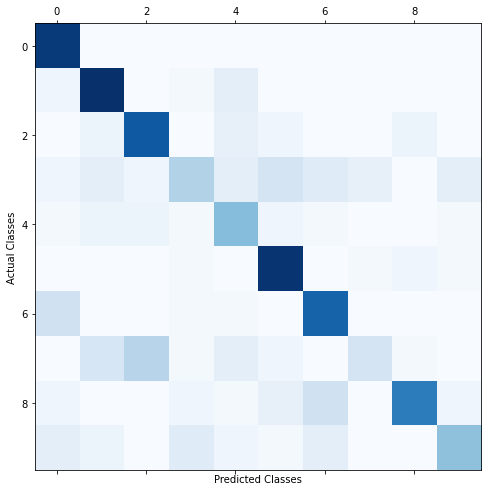

In [ ]:
plt.figure(figsize=(16,8))
plt.matshow(conf_mx,cmap=plt.cm.Blues,fignum=1)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.show()

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

# Try InceptionV3

In [ ]:
input_shape

(259, 13, 1)

In [ ]:
#image_data = '/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/images_original/'
image_data = '/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/spectrograms512_train/'

In [ ]:
BATCH_SIZE=8
TARGET_SIZE=224
NUM_CLASSES=10

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_ds = image_dataset_from_directory(
  image_data,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(TARGET_SIZE, TARGET_SIZE),
  #image_size=(432,288),
  #batch_size=BATCH_SIZE
  )

Found 999 files belonging to 10 classes.
Using 800 files for training.


In [ ]:
val_ds = image_dataset_from_directory(
  image_data,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(TARGET_SIZE, TARGET_SIZE),
  #image_size=(432,288),
  #batch_size=BATCH_SIZE
  )

Found 999 files belonging to 10 classes.
Using 199 files for validation.


In [ ]:
import tensorflow_hub as hub

feature_extractor_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url)
feature_extractor_layer.trainable = False

In [ ]:
model9 = models.Sequential()
model9.add(feature_extractor_layer)
model9.add(layers.Dropout(.2))
model9.add(layers.Dense(units=10, activation=tf.nn.softmax,name = "class_layer"))


In [ ]:
model9.build((None,TARGET_SIZE,TARGET_SIZE,3))

In [ ]:
model9.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_9 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dropout_19 (Dropout)         (None, 2048)              0         
_________________________________________________________________
class_layer (Dense)          (None, 10)                20490     
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model9.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history9 = model9.fit(train_ds
                    ,epochs=200
                    ,validation_data=(val_ds)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Models/Model9/model9_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
100/100 [==============================] - 16s 138ms/step - loss: 219.3885 - accuracy: 0.1358 - val_loss: 174.8406 - val_accuracy: 0.1156
Epoch 2/200
100/100 [==============================] - 14s 132ms/step - loss: 160.3256 - accuracy: 0.2019 - val_loss: 82.8479 - val_accuracy: 0.2161
Epoch 3/200
100/100 [==============================] - 13s 129ms/step - loss: 138.1465 - accuracy: 0.2477 - val_loss: 125.4328 - val_accuracy: 0.1809
Epoch 4/200
100/100 [==============================] - 13s 129ms/step - loss: 168.8533 - accuracy: 0.2395 - val_loss: 95.5253 - val_accuracy: 0.2462
Epoch 5/200
100/100 [==============================] - 13s 129ms/step - loss: 119.0796 - accuracy: 0.2886 - val_loss: 99.0228 - val_accuracy: 0.3668
Epoch 6/200
100/100 [==============================] - 13s 127ms/step - loss: 122.9868 - accuracy: 0.2787 - val_loss: 97.3845 - val_accuracy: 0.2211
Epoch 7/200
100/100 [==============================] - 14s 141ms/step - loss: 107.9755 - accuracy: 0.303

### MobileNetV2

In [ ]:
IMG_SIZE=(512,512)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:

feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url)
feature_extractor_layer.trainable = False

In [ ]:
model10 = models.Sequential()
model10.add(feature_extractor_layer)
model10.add(layers.Dropout(.3))
model10.add(layers.Dense(units=10, activation=tf.nn.softmax,name = "class_layer"))


In [ ]:
model10.build((None,TARGET_SIZE,TARGET_SIZE,3))

In [ ]:
base_model.build((None,TARGET_SIZE,TARGET_SIZE,3))

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
base_model.compile(optimizer='adam',
              loss='categorical_crossentropy',#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model10.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
val_ds

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
historybase = .fit(train_ds
                    ,epochs=200
                    ,validation_data=val_ds
                    #,callbacks=[
                    #tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
                    #tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Models/Model10/model10_{val_accuracy:.4f}.h5', save_best_only=True,
                    #                    save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200


ValueError: ignored

In [ ]:
history10 = model10.fit(train_ds
                    ,epochs=200
                    ,validation_data=(val_ds)
                    #,callbacks=[
                    #tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
                    #tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Models/Model10/model10_{val_accuracy:.4f}.h5', save_best_only=True,
                    #                    save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
25/25 [==============================] - 20s 450ms/step - loss: 2.7180 - accuracy: 0.1317 - val_loss: 1.8988 - val_accuracy: 0.2764
Epoch 2/200
25/25 [==============================] - 12s 412ms/step - loss: 2.1830 - accuracy: 0.2225 - val_loss: 1.7448 - val_accuracy: 0.4171
Epoch 3/200
25/25 [==============================] - 12s 404ms/step - loss: 1.8970 - accuracy: 0.3194 - val_loss: 1.6391 - val_accuracy: 0.4020
Epoch 4/200
25/25 [==============================] - 12s 410ms/step - loss: 1.7738 - accuracy: 0.3657 - val_loss: 1.6216 - val_accuracy: 0.4171
Epoch 5/200
25/25 [==============================] - 12s 404ms/step - loss: 1.6436 - accuracy: 0.3862 - val_loss: 1.5640 - val_accuracy: 0.4623
Epoch 6/200
25/25 [==============================] - 12s 407ms/step - loss: 1.6868 - accuracy: 0.4168 - val_loss: 1.5576 - val_accuracy: 0.4271
Epoch 7/200
25/25 [==============================] - 12s 410ms/step - loss: 1.6071 - accuracy: 0.4591 - val_loss: 1.5621 - val_accuracy:

## Build neural net for CSV file

### 3 second clip csv model

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/features_3_sec.csv')
df.head()

filename  length  chroma_stft_mean  ...  mfcc20_mean  mfcc20_var  label
0  blues.00000.0.wav   66149          0.335406  ...    -0.243027   43.771767  blues
1  blues.00000.1.wav   66149          0.343065  ...     5.784063   59.943081  blues
2  blues.00000.2.wav   66149          0.346815  ...     2.517375   33.105122  blues
3  blues.00000.3.wav   66149          0.363639  ...     3.630866   32.023678  blues
4  blues.00000.4.wav   66149          0.335579  ...     0.536961   29.146694  blues

[5 rows x 60 columns]

In [ ]:
df.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [ ]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [ ]:
# update labels in df to index
df.label = [label_index[l] for l in df.label]

In [ ]:
import sklearn.metrics as skm
import sklearn.model_selection as skms
seed=123
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [ ]:
df=df.astype('float64').dtypes

In [ ]:
import sklearn.preprocessing as skp
#Scale Data
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [ ]:
model11 = models.Sequential()
model11.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model11.add(layers.Dense(128, activation='relu'))
model11.add(layers.Dense(64, activation='relu'))
model11.add(layers.Dense(10, activation='softmax'))

In [ ]:
model11.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 256)               14848     
_________________________________________________________________
dense_36 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_37 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_38 (Dense)             (None, 10)                650       
Total params: 56,650
Trainable params: 56,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model11.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy'
    )

In [ ]:
history11 = model11.fit(X_train
                    ,y_train
                    ,epochs=200
                    ,validation_data=(X_dev, y_dev)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Models/Model11/model11_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )  

Epoch 1/200
219/219 [==============================] - 1s 4ms/step - loss: 1.4574 - accuracy: 0.4867 - val_loss: 0.8336 - val_accuracy: 0.7073
Epoch 2/200
219/219 [==============================] - 1s 3ms/step - loss: 0.6930 - accuracy: 0.7694 - val_loss: 0.6412 - val_accuracy: 0.7831
Epoch 3/200
219/219 [==============================] - 1s 3ms/step - loss: 0.5415 - accuracy: 0.8237 - val_loss: 0.5782 - val_accuracy: 0.8018
Epoch 4/200
219/219 [==============================] - 1s 3ms/step - loss: 0.4208 - accuracy: 0.8589 - val_loss: 0.5061 - val_accuracy: 0.8342
Epoch 5/200
219/219 [==============================] - 1s 3ms/step - loss: 0.3172 - accuracy: 0.8962 - val_loss: 0.5047 - val_accuracy: 0.8337
Epoch 6/200
219/219 [==============================] - 1s 3ms/step - loss: 0.2610 - accuracy: 0.9184 - val_loss: 0.4515 - val_accuracy: 0.8498
Epoch 7/200
219/219 [==============================] - 1s 3ms/step - loss: 0.1911 - accuracy: 0.9411 - val_loss: 0.4889 - val_accuracy: 0.8438

In [ ]:
model11 = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Models/Model11/model11_0.9110.h5')

In [ ]:
loss, accuracy = model11.evaluate(X_test, y_test)
print('test set accuracy: ', accuracy * 100)

32/32 [==============================] - 0s 1ms/step - loss: 0.4933 - accuracy: 0.9078
test set accuracy:  90.77526926994324


In [ ]:
pred_classes = np.argmax(model11.predict(X_test), axis=-1)
pred_classes

array([0, 7, 0, ..., 5, 9, 5])

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[97,  0,  1,  0,  0,  0,  2,  0,  0,  2],
       [ 1, 94,  0,  1,  1,  4,  0,  0,  0,  0],
       [ 5,  1, 87,  1,  0,  4,  0,  1,  0,  3],
       [ 0,  0,  0, 90,  0,  0,  5,  4,  1,  2],
       [ 0,  0,  1,  0, 91,  0,  3,  0,  5,  2],
       [ 2,  3,  1,  0,  0, 95,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 98,  0,  1,  3],
       [ 0,  0,  3,  0,  3,  1,  0, 90,  4,  1],
       [ 0,  0,  1,  3,  2,  0,  0,  0, 95,  1],
       [ 2,  0,  3,  4,  0,  2,  2,  1,  0, 88]], dtype=int32)>

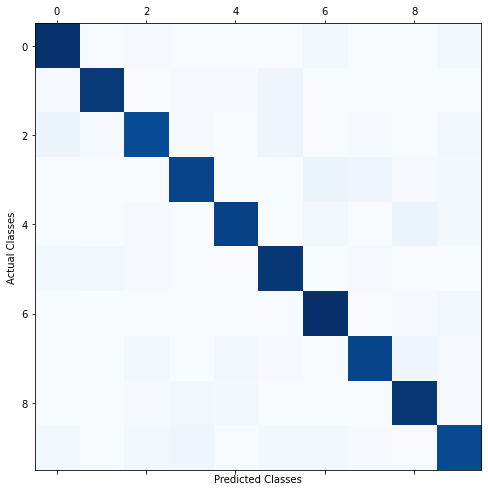

In [ ]:
plt.figure(figsize=(16,8))
plt.matshow(conf_mx,cmap=plt.cm.Blues,fignum=1)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.show()

### 30 second clip csv model

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Data/features_30_sec.csv')
df.head()

filename  length  chroma_stft_mean  ...  mfcc20_mean  mfcc20_var  label
0  blues.00000.wav  661794          0.350088  ...     1.221291   46.936035  blues
1  blues.00001.wav  661794          0.340914  ...     0.531217   45.786282  blues
2  blues.00002.wav  661794          0.363637  ...    -2.231258   30.573025  blues
3  blues.00003.wav  661794          0.404785  ...    -3.407448   31.949339  blues
4  blues.00004.wav  661794          0.308526  ...   -11.703234   55.195160  blues

[5 rows x 60 columns]

In [ ]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [ ]:
# update labels in df to index
df.label = [label_index[l] for l in df.label]

In [ ]:
import sklearn.metrics as skm
import sklearn.model_selection as skms
seed=123
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [ ]:
import sklearn.preprocessing as skp
#Scale Data
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [ ]:
model12 = models.Sequential()
model12.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model12.add(layers.Dense(128, activation='relu'))
model12.add(layers.Dense(64, activation='relu'))
model12.add(layers.Dense(10, activation='softmax'))

In [ ]:
model12.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy'
    )

In [ ]:
history12 = model12.fit(X_train
                    ,y_train
                    ,epochs=200
                    ,validation_data=(X_dev, y_dev)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Models/Model12/model12_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )  

Epoch 1/200
22/22 [==============================] - 1s 16ms/step - loss: 2.1509 - accuracy: 0.2512 - val_loss: 1.5845 - val_accuracy: 0.4444
Epoch 2/200
22/22 [==============================] - 0s 5ms/step - loss: 1.3967 - accuracy: 0.5386 - val_loss: 1.2147 - val_accuracy: 0.5455
Epoch 3/200
22/22 [==============================] - 0s 5ms/step - loss: 0.9898 - accuracy: 0.6700 - val_loss: 1.0293 - val_accuracy: 0.6364
Epoch 4/200
22/22 [==============================] - 0s 5ms/step - loss: 0.7594 - accuracy: 0.7693 - val_loss: 0.9581 - val_accuracy: 0.6616
Epoch 5/200
22/22 [==============================] - 0s 5ms/step - loss: 0.5411 - accuracy: 0.8361 - val_loss: 0.9234 - val_accuracy: 0.6566
Epoch 6/200
22/22 [==============================] - 0s 5ms/step - loss: 0.5180 - accuracy: 0.8622 - val_loss: 0.9419 - val_accuracy: 0.6364
Epoch 7/200
22/22 [==============================] - 0s 5ms/step - loss: 0.3977 - accuracy: 0.8887 - val_loss: 0.9360 - val_accuracy: 0.6313
Epoch 8/200


In [ ]:
model12 = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/Assignment4/Models/Model12/model12_0.7121.h5')

In [ ]:
loss, accuracy = model12.evaluate(X_test, y_test)
print('test set accuracy: ', accuracy * 100)

4/4 [==============================] - 0s 2ms/step - loss: 0.9139 - accuracy: 0.7353
test set accuracy:  73.52941036224365
